# 1. Data exploration and cleaning
In this notebook we will begin with the initial exploration and cleaning of the datasets for the Publications track of Hércules challenge.

## Setup

In [1]:
import logging
import os
import sys

# set up module paths for imports
module_path = os.path.abspath(os.path.join('..'))
sys.path.append(module_path)

# start logging system and set logging level
logger = logging.getLogger()
logger.setLevel(logging.INFO)
logging.info("Starting logger")

INFO:root:Starting logger


In [2]:
DATA_DIR = os.path.join(module_path, 'data')

## Dataset 1: COVID-19

## Dataset 2: Agriculture

### Getting the article IDs to retrieve

In [3]:
article_ids_file = os.path.join(DATA_DIR, 'pmc_ids.txt')

def load_ids(base_file):
    with open(base_file , 'r') as f:
        ids = f.read().splitlines()
    return ids


In [4]:
article_ids = load_ids(article_ids_file)
len(article_ids)

127

In [5]:
article_ids[0]

'PMC3310815'

### Loading the XML data from the EuropeBMC API

In [6]:
BMC_BASE_API = 'https://www.ebi.ac.uk/europepmc/webservices/rest'

In [7]:
import requests

def load_pmc_data(ids_to_download):
    return {pmc_id: requests.get(f"{BMC_BASE_API}/{pmc_id}/fullTextXML").content 
            for pmc_id in ids_to_download}

pmc_dataset_xml = load_pmc_data(article_ids)

Since one of the articles is not available for reuse ('PMC6472519') we are going to remove it from the whole track in order to comply with its license. More information about this issue can be found at https://github.com/weso-edma/hercules-challenge-publications/issues/3.

In [8]:
del pmc_dataset_xml['PMC6472519']

### Parsing the data

In [14]:
class PMCArticle():
    def __init__(self, article_id, title, authors, abstract,
                 full_body, references_titles, subjects):
        self.article_id = article_id
        self.authors = authors
        self.abstract = abstract
        self.full_body = full_body
        self.title = title
        self.references_titles = references_titles
        self.subjects = subjects
    
    def to_dict(self):
        return {
            'id': self.article_id,
            'title': self.title,
            'abstract': self.abstract,
            'full_body': self.full_body,
            'authors': '|'.join(self.authors),
            'references': '|'.join(self.references_titles),
            'subjects': '|'.join(self.subjects)
        }
    
    def __eq__(self, other):
        if other is None or not isinstace(other, PMCArticle):
            return False
        return self.article_id == other.article_id
        
    def __repr__(self):
        return str(self)
    
    def __str__(self):
        return f"{self.article_id} - {self.title} - {self.abstract[:10]}... - {self.full_body[:20]}..."


In [40]:
from bs4 import BeautifulSoup


def get_abstract(article_soup):
    return article_soup.find('abstract').text

def get_authors(article_soup):
    return [author.find('name').get_text(separator=' ') 
            for author in article_soup.find_all('contrib', 
                                        {'contrib-type': 'author'})]

def get_full_body(article_soup):
    return article_soup.find('body').get_text(separator=' ')

def get_title(article_soup):
    return article_soup.find('article-title').text

def get_pmc_id(article_soup):
    return article_soup.find('article-id', {'pub-id-type': 'pmcid'}).text

def get_references_titles(article_soup):
    return [reference.find('article-title').text
            for reference in article_soup.find_all('ref')
            if reference.find('article-title')]

def get_subjects(article_soup):
    return [subj.text 
            for subj in article_soup.find_all('subject')
            if subj.text.lower() not in ['review', 'article', 'research article']]

def parse_pmc_article(article_xml):
    soup = BeautifulSoup(article_xml, 'lxml-xml')
    return PMCArticle(get_pmc_id(soup), get_title(soup),
                      get_authors(soup), get_abstract(soup),
                      get_full_body(soup), get_references_titles(soup),
                      get_subjects(soup))


In [41]:
pmc_articles = [parse_pmc_article(article_xml) for article_xml in pmc_dataset_xml.values()]
pmc_articles[0]

3310815 - Induced Release of a Plant-Defense Volatile ‘Deceptively’ Attracts Insect Vectors to Plants Infected with a Bacterial Pathogen - Transmissi... - Introduction Transmi...

### Creating the dataframe

In [42]:
import pandas as pd

pmc_df = pd.DataFrame.from_records([article.to_dict() for article in pmc_articles])
pmc_df.head(n=7)

,id,title,abstract,full_body,authors,references,subjects
0,3310815,Induced Release of a Plant-Defense Volatile ‘D...,Transmission of plant pathogens by insect vect...,Introduction Transmission of plant pathogens b...,Mann Rajinder S.|Ali Jared G.|Hermann Sara L.|...,Insect vector relationships with procaryotic p...,Agriculture|Crops|Pest Control|Biology|Ecology...
1,3547067,Carbon and Nitrogen Isotopic Survey of Norther...,The development of isotopic baselines for comp...,Introduction Stable isotope analysis is an imp...,Szpak Paul|White Christine D.|Longstaffe Fred ...,Influence of diet on the distribution of carbo...,Biology|Ecology|Biogeochemistry|Paleontology|P...
2,3668195,The effect of ‘Candidatus Liberibacter asiatic...,BackgroundHuanglongbing (HLB) is a highly dest...,Background Citrus Huanglongbing (HLB) or citru...,Nwugo Chika C|Lin Hong|Duan Yongping|Civerolo ...,"Huanglongbing: a destructive, newly-emerging, ...",
3,3672096,Emissions of CH4 and N2O under Different Tilla...,Understanding greenhouse gases (GHG) emissions...,Introduction With the current rise in global t...,Zhang Hai-Lin|Bai Xiao-Lin|Xue Jian-Fu|Chen Zh...,Simulation of fluxes of greenhouse gases from ...,Agriculture|Agricultural Biotechnology|Agricul...
4,3676804,"Physiological, Biochemical, and Molecular Mech...",High temperature (HT) stress is a major enviro...,1. Introduction Among the ever-changing compon...,Hasanuzzaman Mirza|Nahar Kamrun|Alam Md. Mahab...,Climate change 2007–The physical science basis...,
5,3676838,Plant Defense against Insect Herbivores,Plants have been interacting with insects for ...,1. Introduction Land plants and insects have c...,Fürstenberg-Hägg Joel|Zagrobelny Mika|Bak Søren,Butterflies and plants: A study in coevolution...,
6,3818224,Enhanced Methanol Production in Plants Provide...,Plants naturally emit methanol as volatile org...,Introduction Insect pests cause approximately ...,Dixit Sameer|Upadhyay Santosh Kumar|Singh Harp...,Pesticides and pest control|Biotechnology as a...,


In [43]:
pmc_df.iloc[82]

id                                                      6213855
title         Importance of Mineral Nutrition for Mitigating...
abstract      Aluminum (Al) toxicity is one of the major lim...
full_body     1. Introduction Aluminum (Al) toxicity represe...
authors       Rahman Md. Atikur|Lee Sang-Hoon|Ji Hee Chung|K...
references    Plant adaptation to aid soils: The molecular b...
subjects                                                       
Name: 82, dtype: object

In [134]:
pmc_df.iloc[0].full_body[:300]

'Introduction Transmission of plant pathogens by insect vectors is a complex biological process involving interactions between the plant, insect, and pathogen  [1] – [2] . Pathogens can induce changes in the traits of their primary hosts as well as their vectors to affect the frequency and nature of '

### Initial exploration of the data

We will begin by checking if there are any empty or null values in our dataset:

In [49]:
pmc_df.isnull().sum()

id            0
title         0
abstract      0
full_body     0
authors       0
references    0
subjects      0
dtype: int64

Although there is no null value in the dataset, some of the strings could be empty still. We are going to quickly check this by iterating over all of the columns from the df:

In [70]:
for col in pmc_df.columns:
    print(col)
    print('-' * len(col))
    print(pmc_df[pmc_df[col] == ''].index)
    print('\n')


id
--
Int64Index([], dtype='int64')


title
-----
Int64Index([], dtype='int64')


abstract
--------
Int64Index([], dtype='int64')


full_body
---------
Int64Index([], dtype='int64')


authors
-------
Int64Index([], dtype='int64')


references
----------
Int64Index([], dtype='int64')


subjects
--------
Int64Index([  2,   4,   5,   6,  15,  18,  19,  21,  22,  23,  24,  28,  30,
             32,  33,  35,  36,  37,  42,  43,  52,  53,  55,  56,  57,  58,
             59,  61,  62,  63,  64,  66,  69,  70,  72,  74,  81,  82,  91,
             93,  95,  97,  98,  99, 103, 104, 105, 106, 107, 108, 111, 112,
            113, 115, 117, 118, 119, 120, 121, 123, 125],
           dtype='int64')




We can see above that some of the articles have an empty value for its subjects. However, every other cells contains some information.

In [96]:
def clean(text):
    text = text.replace(u'\u200a', ' ')
    return re.sub(' +', ' ', text).strip()


In [97]:
pmc_df['text_cleaned'] = pmc_df['full_body'].apply(lambda x: clean(x))
pmc_df['text_cleaned'].loc[0][:500]

'Introduction Transmission of plant pathogens by insect vectors is a complex biological process involving interactions between the plant, insect, and pathogen [1] – [2] . Pathogens can induce changes in the traits of their primary hosts as well as their vectors to affect the frequency and nature of interactions between hosts and vectors [3] – [13] . Plant morphology, as well as, primary and secondary plant compounds, including emitted volatiles and plant nutrients, are some of the traits that can'

In [130]:
pmc_df['num_chars_text'] = pmc_df['text_cleaned'].apply(lambda x: len(x))

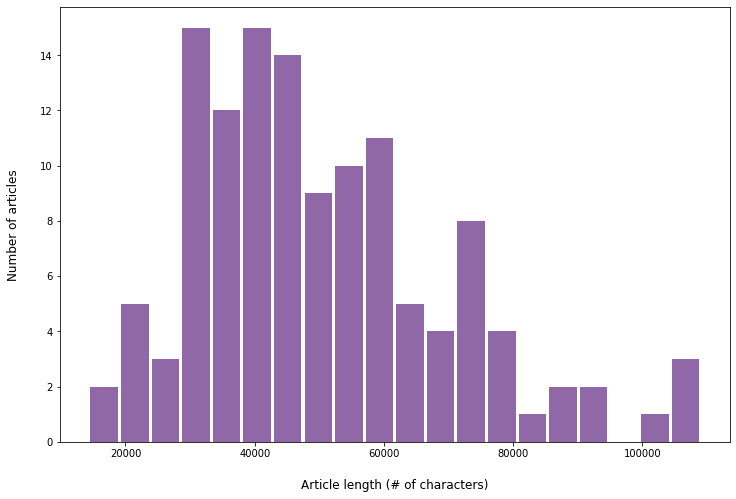

In [136]:
def plot_df_hist(df, col, x_label, y_label, color='#9067a7'):
    ax = df.hist(column=col, bins=20, figsize=(12,8), color=color, zorder=2, rwidth=0.9, grid=False)
    ax = ax[0]
    for x in ax:
        x.set_title("")
        x.set_xlabel(x_label, labelpad=20, size=12)
        x.set_ylabel(y_label, labelpad=20, size=12)

plot_df_hist(pmc_df, 'num_chars_text', 'Article length (# of characters)', 'Number of articles')

In [ ]:
pmc_df['num_chars_text'].describe()

### Serializing the dataframe

In [47]:
PMC_FILE_PATH = os.path.join(DATA_DIR, 'pmc_dataframe.pkl')

pmc_df.to_pickle(PMC_FILE_PATH)